In [61]:
import numpy as np
import pandas as pd
from pandas.core import nanops

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [71]:
CORRELATION_METHOD = 'spearman' # 'pearson' or 'spearman'
NEIGHBORHOOD_METHOD = 'threshold' # 'threshold' or 'number'
SIMILARITY_THRESHOLD = 0.7 # only used if NEIGHBORHOOD_METHOD = 'threshold'
N_NEIGHBORS = 50 # only used if NEIGHBORHOOD_METHOD = 'number'
MIN_N_CO_RATED = 10 # minimum number of co-rated items to be considered as neighbor
MIN_N_RATINGS = 5 # minimum number of ratings per item need from neighbors to make prediction
DEVIATION_FROM_MEAN = False # if to make prediction as deviation from mean
N_RUNS = 3

In [63]:
books = pd.read_csv("books.csv")[["book_id", "title", "authors"]]
ratings = pd.read_csv("ratings.csv")

In [64]:
user_ids = ratings.user_id.unique()
num_users = len(user_ids)
print(f"Number of user: {num_users}")

Number of user: 53424


In [65]:
class CollaborativeFilter():
    def __init__(self, ratings: pd.DataFrame, 
                 user_col: str="user_id", 
                 item_col: str="book_id",
                 neighborhood_method: str='threshold',
                 correlation_method: str='pearson',
                 minimal_similarity: float=0.7,
                 number_of_neighbors: int=50,
                 minimum_number_of_books_rated_in_common: int=10,
                 minimal_number_of_ratings: int=5,
                 deviation_from_mean: bool=True) -> None:
        self.ratings = ratings
        self.user_col = user_col
        self.item_col = item_col
        
        self.user_means = ratings[[self.user_col, 'rating']].groupby(self.user_col).agg("mean")
        
        self.neighborhood_method = neighborhood_method
        self.correlation_method = correlation_method
        self.minimal_similarity = minimal_similarity
        self.minimum_number_of_books_rated_in_common = minimum_number_of_books_rated_in_common
        self.minimal_number_of_ratings = minimal_number_of_ratings
        self.deviation_from_mean = deviation_from_mean
        
    def get_similarities(self, input_ratings: pd.DataFrame, user_id: int) -> pd.DataFrame:
        ratings = pd.concat([self.ratings, input_ratings])
        relevant_ratings = pd.merge(ratings, input_ratings[self.item_col], on=[self.item_col], how='inner')
        uii_matrix = relevant_ratings.pivot_table(
          index=[self.user_col], 
          columns=[self.item_col], 
          values="rating")

        similarities = uii_matrix.corrwith(
            uii_matrix.loc[user_id], 
            axis=1, 
            method=lambda x,y: nanops.nancorr(x, y, min_periods=self.minimum_number_of_books_rated_in_common, method=self.correlation_method))
        
        # Remove self similarity
        similarities[user_id] = np.nan
        similarities = similarities.dropna()
        
        # Consider those users with at least a similarity of minimal_similarity
        if self.neighborhood_method == 'threshold':
            similarities = similarities[similarities>self.minimal_similarity]
        elif self.neighborhood_method == 'number':
            similarities = similarities.nlargest(n=self.number_of_neighbors)
        similarities.name = 'similarities'
        return similarities
    
    def scoring(self, column, similarities: pd.Series, input_mean: float) -> float:
        # If book has been rated less than minimal_number_of_ratings, set its score to nan
        if column.notna().sum() < self.minimal_number_of_ratings:
            return np.nan
        
        # Calculate weighted mean of ratings as scores
        denominator = np.sum(similarities[column.notna()])
        if self.deviation_from_mean:
            user_means = pd.merge(self.user_means, similarities[column.notna()], left_index=True, right_index=True, how='inner')
            numerator = np.sum(column*similarities) - \
                (user_means['rating']*user_means['similarities']).sum()
            return input_mean+numerator/denominator if denominator != 0 else np.nan
        else:
            numerator = np.sum(column*similarities)
            return numerator/denominator if denominator != 0 else np.nan
    
    def get_scores(self, similarities: pd.Series, input_ratings: pd.DataFrame) -> pd.DataFrame:
        relevant_ratings = pd.merge(self.ratings, similarities, left_on=[self.user_col], how='inner', right_index=True)
        uii_matrix = relevant_ratings.pivot_table(
          index=[self.user_col], 
          columns=[self.item_col], 
          values="rating")
        
        predicted_scores = uii_matrix.apply(
            lambda x: self.scoring(x, similarities, input_mean=input_ratings['rating'].mean()))
        return predicted_scores

In [66]:
def cf_experiment(
    ratings: pd.DataFrame, 
    neighborhood_method: str='threshold',
    correlation_method: str='pearson',
    minimal_similarity: float=0.7,
    number_of_neighbors: int=50,
    minimum_number_of_books_rated_in_common: int=10,
    minimal_number_of_ratings: int=5,
    deviation_from_mean: bool=True,
    number_of_runs: int=1):
    kf = KFold(n_splits=num_users, shuffle=True, random_state=42)
    kf.get_n_splits(user_ids)

    coverage = []
    mae = []

    for i, (train_index, test_index) in enumerate(kf.split(user_ids)):
        print(f"Fold {i}:")
        train_user_ids, test_user_ids = user_ids[train_index], user_ids[test_index]
        test_user_id = test_user_ids[0]
        train_ratings, test_ratings = ratings[ratings.user_id.isin(train_user_ids)], \
                                        ratings[ratings.user_id.isin(test_user_ids)]
        input_ratings, heldout_ratings = train_test_split(test_ratings, 
                                                          stratify=test_ratings.user_id, 
                                                          test_size=0.1, 
                                                          random_state=42)

        cf = CollaborativeFilter(train_ratings,
                                 neighborhood_method=neighborhood_method,
                                 correlation_method=correlation_method,
                                 minimal_similarity=minimal_similarity,
                                 number_of_neighbors=number_of_neighbors,
                                 minimum_number_of_books_rated_in_common=minimum_number_of_books_rated_in_common,
                                 minimal_number_of_ratings=minimal_number_of_ratings,
                                 deviation_from_mean=deviation_from_mean)
        similarities = cf.get_similarities(input_ratings, test_user_id)
        predicted_scores = cf.get_scores(similarities, input_ratings)
    
        predictions = heldout_ratings.merge(predicted_scores.rename('scores'), on='book_id', how='left')
        coverage.append(1-predictions.scores.isna().sum()/len(predictions))
        mae.append((predictions.rating-predictions.scores).abs().mean())

        if i==number_of_runs-1:
            break
    return coverage, mae

In [ ]:
coverages, maes = [], []
minimal_similarities = np.linspace(0.3, 0.7, 3)
for minimal_similarity in minimal_similarities:
    coverage, mae = cf_experiment(
    ratings=ratings, 
    neighborhood_method=NEIGHBORHOOD_METHOD,
    correlation_method=CORRELATION_METHOD,
    minimal_similarity=minimal_similarity,
    number_of_neighbors=N_NEIGHBORS,
    minimum_number_of_books_rated_in_common=MIN_N_CO_RATED,
    minimal_number_of_ratings=MIN_N_RATINGS,
    number_of_runs=N_RUNS,
    deviation_from_mean=DEVIATION_FROM_MEAN)
    coverages.append(coverage)
    maes.append(mae)

Fold 0:
Fold 1:
Fold 2:
Fold 0:
Fold 1:
Fold 2:
Fold 0:
Fold 1:
Fold 2:


In [66]:
# %time coverage, mae = collaborative_filter(ratings=ratings, minimum_number_of_books_rated_in_common=minimum_number_of_books_rated_in_common,minimal_similarity=minimal_similarity,minimal_number_of_ratings=minimal_number_of_ratings,number_of_runs=1)

Fold 0:
CPU times: user 11.4 s, sys: 67.4 ms, total: 11.4 s
Wall time: 11.4 s


In [14]:
def pool_experiment(minimal_similarity):
    return cf_experiment(
    ratings=ratings, 
    minimum_number_of_books_rated_in_common=minimum_number_of_books_rated_in_common,
    minimal_similarity=minimal_similarity,
    minimal_number_of_ratings=minimal_number_of_ratings,
    number_of_runs=number_of_runs)

In [18]:
with ProcessPoolExecutor(max_workers=3) as executor:
    results = executor.map(pool_experiment, minimal_similarities).result()

In [ ]:
results

In [ ]:
coverages = np.array(coverages)
maes = np.array(maes)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(minimal_similarities, np.mean(maes, axis=1), xerr=0., yerr=np.var(maes, axis=1))
plt.show()

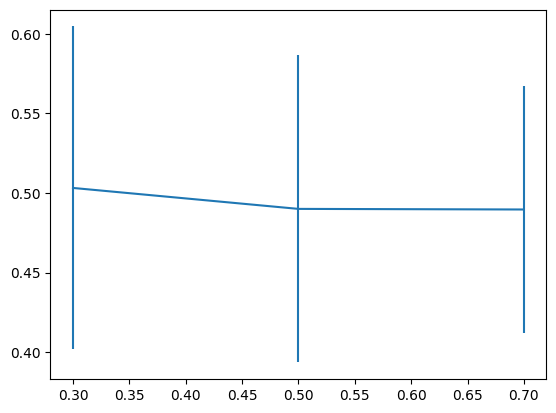

In [69]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(minimal_similarities, np.mean(maes, axis=1), xerr=0., yerr=np.var(maes, axis=1))
plt.show()

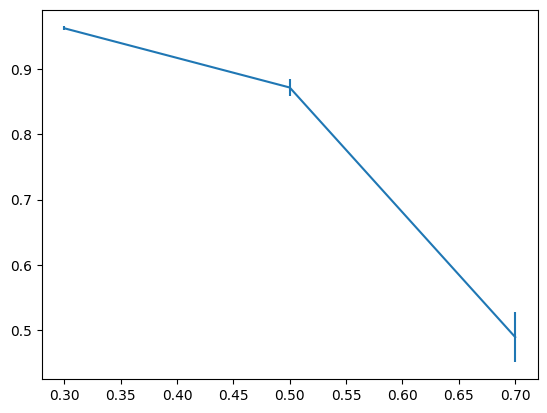

In [70]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(minimal_similarities, np.mean(coverages, axis=1), xerr=0., yerr=np.var(coverages, axis=1))
plt.show()